# The irreducible mass of black holes.

Consider a rotating black hole. In 1969, Roger Penrose (now Nobel Prize in Physics for the theory of black holes) discovered that one can extract energy from a rotating black hole:  
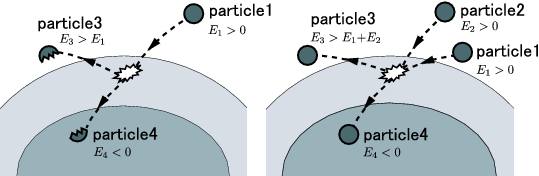  

For a BH of mass $M$ and spin $\chi\in[0,1]$, the irreducible mass is  
<center>$M_{irr} = M \sqrt{\frac{1+\sqrt{1-\chi^2}}{2}}$</center>  
For convenience let us define  
<center>$f(\chi) = \sqrt{\frac{1+\sqrt{1-\chi^2}}{2}} = \frac{M_{irr}}{M} $</center>

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import norm
from astropy.visualization.hist import hist as fancyhist
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV
from tqdm import tqdm
#import re
#import math

Let's assume that
- the spin $\chi$ is uniformly distributed between 0 and 1
- the mass $M$ is normally distributed with mean $\mu$ and standard deviation $\sigma$  

These are simplistic assumption that, however, are not too far from what we are now measuring with gravitational-wave detectors. It's a toy model, but not a totally unreasonable one.

Start with a value of $\sigma = 0.02$. This is a scale and not a parameter: you can normalize all quantities with a dimension of mass by $\mu$. Just set $\mu = 1$ in the code and remember that all masses in the problem are measured in units of $\mu$.

In [2]:
mu = 1
sigma = 0.02
N = 10000
spin = np.random.uniform(0, 1, N)
M = norm(mu, sigma).rvs(N)

In [3]:
M_irr = M * np.sqrt( (1 + np.sqrt(1-spin**2)) / 2 )

I plot the resulting $M_{irr}$.

In [4]:
# binning through Scott's rule
def bin_width(data):
    bin_width = (3.5*sigma) / (N**(1/3))
    return np.append(np.arange(start=data.min(), stop=data.max(), step=bin_width), data.max())

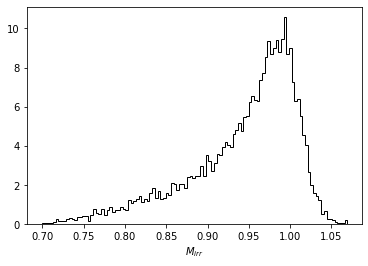

In [5]:
plt.hist(M_irr, bins=bin_width(M_irr), density=True, histtype='step', edgecolor='black')
plt.xlabel(r'$M_{irr}$')
plt.show()

In [6]:
x = np.linspace(M_irr.min(), M_irr.max(), 100)

Using the same samples, i plot the distribution of $M_{irr}$ using a KDE.

In [7]:
def kde_sklearn(data, bandwidth, kernel="linear"):
    kde_skl = KernelDensity(bandwidth = bandwidth, 
                            kernel=kernel)
    kde_skl.fit(data[:, np.newaxis])
    log_pdf = kde_skl.score_samples(x[:, np.newaxis]) # sklearn returns log(density)

    return np.exp(log_pdf)

In [14]:
bwrange = np.linspace(0.01,1.0, 10)
print(bwrange)
K = 5 # 5-fold cross validation
grid = GridSearchCV(KernelDensity(), {'bandwidth': bwrange}, cv= K)
grid.fit(M_irr[:,np.newaxis])
h_opt = grid.best_params_['bandwidth']
print(h_opt)

[0.01 0.12 0.23 0.34 0.45 0.56 0.67 0.78 0.89 1.  ]
0.01


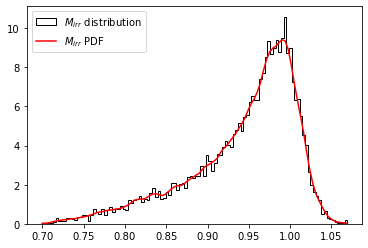

In [15]:
PDF_M = kde_sklearn(M_irr, bandwidth=h_opt, kernel="epanechnikov")
h_Mirr = fancyhist(M_irr, bins=bin_width(M_irr), histtype="step", edgecolor='black', density=True, label=r'$M_{irr}$ distribution')
plt.plot(x, PDF_M, color='red', label=r'$M_{irr}$ PDF')
plt.legend(loc='upper left')
plt.show()

And the same for $f$.

In [36]:
#f = M_irr / M
def f_function(spin):
    return ((1+(1-spin**2)**0.5)/2)**0.5

f = f_function(spin)

In [37]:
bwrange = np.linspace(0.001,1.0, 10)
print(bwrange)
K = 5 # 5-fold cross validation
grid = GridSearchCV(KernelDensity(), {'bandwidth': bwrange}, cv= K)
grid.fit(f[:,np.newaxis])
h_opt = grid.best_params_['bandwidth']
print(h_opt)

[0.001 0.112 0.223 0.334 0.445 0.556 0.667 0.778 0.889 1.   ]
0.001


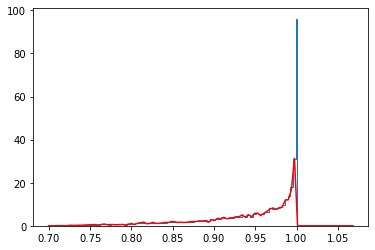

In [52]:
PDF_f = kde_sklearn(f, bandwidth=0.001, kernel="epanechnikov")
h_f = fancyhist(f, bins=bin_width(f), histtype="step", density=True)
plt.plot(x, PDF_f, color='red')
plt.show()

In [47]:
counts_Mirr, bin_edges_Mirr = np.histogram(M_irr, bins=100, density=True)
pdf_Mirr = counts_Mirr / np.sum(counts_Mirr)
cdf_Mirr = np.cumsum(pdf_Mirr)

counts_f, bin_edges_f = np.histogram(f, bins=100, density=True)
pdf_f = counts_f / np.sum(counts_f)
cdf_f = np.cumsum(pdf_f)

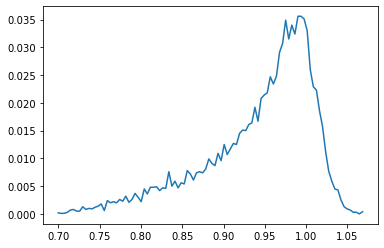

In [48]:
plt.plot(x, pdf_Mirr)
plt.show()

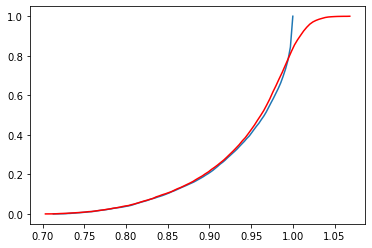

In [53]:
plt.plot(bin_edges_f[1:], cdf_f)
plt.plot(bin_edges_Mirr[1:], cdf_Mirr, color='red')

plt.show()

I compute the KS distance between $M_{irr}$ and $f$ as a function of $\sigma$ and between $M_{irr}$ and $M$ as a function of $\sigma$.

In [54]:
D_fMirr = max(abs(cdf_f - cdf_Mirr))
print(D_fMirr)

counts_M, bin_edges_M = np.histogram(M, bins=100, density=True)
pdf_M = counts_M / np.sum(counts_M)
cdf_M = np.cumsum(pdf_M)

D_MMirr = max(abs(cdf_M - cdf_Mirr))
print(D_MMirr)

0.4852000000000008
0.49860000000000165


I compute the KS distance while varying the sigma values and i discuss the limits at large and small values of $\sigma$.

In [55]:
sigmas = np.arange(0.001, 10, 0.005)
num = 10000

In [56]:
ks_fMirr_vec = []
ks_MMirr_vec = []

pbar = tqdm(total=len(sigmas), desc='for loop')
for s in sigmas:
    spins = np.random.uniform(0, 1, num)
    mass = norm(mu, s).rvs(num)
    irr_mass = mass * np.sqrt( (1 + np.sqrt(1-spin**2)) / 2 )
    
    f_ = irr_mass / mass
    
    ks_fMirr = stats.kstest(f_, irr_mass)
    ks_fMirr_vec.append(ks_fMirr)
    ks_MMirr = stats.kstest(mass, irr_mass)
    ks_MMirr_vec.append(ks_MMirr)
    
    pbar.update(s)
    
pbar.close()

for loop: 9996.999999999993it [00:33, 299.57it/s]                           


In [57]:
stat_fMirr = [result.statistic for result in ks_fMirr_vec]
stat_MMirr = [result.statistic for result in ks_MMirr_vec]

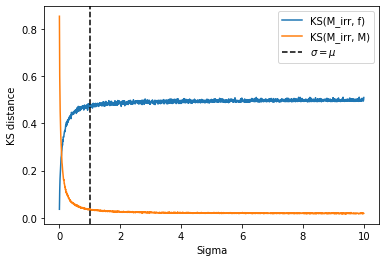

In [60]:
plt.plot(sigmas, stat_fMirr, label='KS(M_irr, f)')
plt.plot(sigmas, stat_MMirr, label='KS(M_irr, M)')
plt.axvline(1, linestyle='dashed', color='black', label=r'$\sigma = \mu$')
plt.xlabel('Sigma')
plt.ylabel('KS distance')
plt.legend()
plt.show()

I can notice that $M_{irr}$ is distributed like $f$ if $\sigma \ll \mu$ (KS distance goes to zero) and $M_{irr}$ is distributed like $M$ if $\sigma \gg \mu$ (KS distance goes to zero).

**Computation of the PDF of $M_{irr}$**

From the theory of change of variable, it's known that 
$$p(y) = \left|\frac{dx}{dy}\right| p(x) \ .$$

I know that $f(\chi) = \sqrt{\frac{1+\sqrt{1-\chi^2}}{2}}$ and i find its inverse on $\chi$: 
$$\chi = \sqrt{1-(2f^2 -1)^2}$$

Its derivative can be computed easily as 

$$\frac{d}{df}(\sqrt{1-(2f^2 -1)^2}) = \frac{-4(2f^2 -1)^2}{\sqrt{1-(2f^2 -1)^2}}$$

and so 

$$\pi(f) = \operatorname{pdf} (\chi) \cdot \left| \frac{-4(2f^2 -1)^2}{\sqrt{1-(2f^2 -1)^2}} \right| = 2 \frac{2f^2 -1}{\sqrt{1-f^2}} \ , $$

where $\operatorname{pdf} (\chi) = 1$ since $\chi$ is uniformly distributed between 0 and 1.